In [ ]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)
ds_pvs, ds_pvs_anoms = open_pvs(da_s)

In [ ]:
da_anti = ds_pvs['anti']
events_mask = da_anti.any(['lon', 'lat']).values
events_indices = np.where(events_mask)[0]
wind_to_pvs_mask = exp_s.da.time.isin(da_anti.time).values
wind_to_pvs_indices = np.where(wind_to_pvs_mask)[0]

In [ ]:
COMPUTE_KWARGS = {
    'n_workers': 12,
    'memory_limit': '4GiB',
}
da = da_s[wind_to_pvs_mask].assign_coords(hourofyear=compute_hourofyear(da_s))
coord = da.hourofyear
da = flox.xarray.rechunk_for_cohorts(
    da,
    dim="time",
    labels=coord,
    force_new_chunk_at=np.linspace(coord.min() // 12, coord.max() // 12, N_WORKERS * 32 + 2, dtype=int)[1:-1] * 12,
    ignore_old_chunks=True,
)
clim = flox.xarray.xarray_reduce(
    da,
    coord,
    func="mean",
    method="cohorts",
).compute(**COMPUTE_KWARGS)

In [ ]:
da_masked_pvs = None
n_offset = 100
for offset in trange(n_offset):
    cond1 = (events_indices + offset) < len(da.time)
    cond2 = da.time.dt.year[events_indices + offset].values == da.time.dt.year[events_indices].values
    cond = cond1 & cond2
    indices = events_indices[cond] + offset
    if da_masked_pvs is None:
        base_coords = {dim: getattr(da, dim).values for dim in da.dims if dim != 'time'}
        coords = {
            'time_around_event': np.arange(n_offset)
        } | base_coords
        da_masked_pvs = xr.DataArray(data=np.zeros([len(c) for c in coords.values()]), coords=coords)
        da_masked_pvs[:] = np.nan
        event_flags = da_anti[indices].max(['lon', 'lat']).values
        events = gpd.read_parquet('/storage/scratch/users/hb22g102/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
        events = events.iloc[event_flags]
    da_masked_pvs[offset, ...] = (da[indices].groupby(da[indices].hourofyear) - clim).mean(dim='time').values
    # print(len(indices))
# indices = np.random.randint(0, len(da.time), size=len(indices))
# (da[indices].groupby(da[indices].hourofyear) - clim).mean(dim='time').plot()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:53<00:00,  1.89it/s]


In [ ]:
COMPUTE_KWARGS = {
    'n_workers': 12,
    'memory_limit': '4GiB',
}
ds = props_as_ds.loc[dict(time=wind_to_pvs_mask)]
ds = ds.assign_coords(hourofyear=compute_hourofyear(ds))
coord = ds.hourofyear
ds = flox.xarray.rechunk_for_cohorts(
    ds,
    dim="time",
    labels=coord,
    force_new_chunk_at=np.linspace(coord.min() // 12, coord.max() // 12, N_WORKERS * 32 + 2, dtype=int)[1:-1] * 12,
    ignore_old_chunks=True,
)
clim_props = flox.xarray.xarray_reduce(
    ds,
    coord,
    func="mean",
    method="cohorts",
).compute(**COMPUTE_KWARGS)

In [ ]:
events = gpd.read_parquet('/storage/scratch/users/hb22g102/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
events = events.iloc[event_flags]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
props_masked_pvs = None
n_offset = 10
for offset in trange(n_offset):
    cond1 = (events_indices + offset) < len(da.time)
    cond2 = da.time.dt.year[events_indices + offset].values == da.time.dt.year[events_indices].values
    cond = cond1 & cond2
    indices = events_indices[cond] + offset
    if props_masked_pvs is None:
        props_masked_pvs = props_as_ds.loc[dict(time=props_as_ds.time[0].values)].reset_coords('time', drop=True)
        for varname in props_masked_pvs.data_vars:
            props_masked_pvs[varname][:] = np.nan
        coords = {
            'event': np.arange(len(indices)),
            'time_around_event': np.arange(n_offset)
        }
        props_masked_pvs = props_masked_pvs.expand_dims(coords).copy(deep=True)
        event_flags = da_anti[indices].max(['lon', 'lat']).values
        events = gpd.read_parquet('/storage/scratch/users/hb22g102/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
        events = events.iloc[event_flags]
        props_masked_pvs = props_masked_pvs.assign_coords(event_flag=('event', event_flags))
        props_masked_pvs = props_masked_pvs.assign_coords(com_x=('event', np.stack(events['com'].values)[:, 0]))
        props_masked_pvs = props_masked_pvs.assign_coords(com_y=('event', np.stack(events['com'].values)[:, 1]))
        props_masked_pvs = props_masked_pvs.assign_coords(mean_var=('event', events['mean_var']))
        props_masked_pvs = props_masked_pvs.assign_coords(event_area=('event', events['event_area']))
        props_masked_pvs = props_masked_pvs.assign_coords(intensity=('event', events['intensity']))
    subds = ds.loc[dict(time=ds.time[indices].values)]
    subds = subds.groupby(subds.hourofyear) - clim_props
    subds = subds.assign_coords(time=np.where(cond)[0]).rename(time='event')
    props_masked_pvs.loc[dict(event=np.where(cond)[0], time_around_event=offset)] = subds
    # print(len(indices))
# indices = np.random.randint(0, len(da.time), size=len(indices))
# (da[indices].groupby(da[indices].hourofyear) - clim).mean(dim='time').plot()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 18.72it/s]


In [ ]:
props_masked_pvs

<xarray.Dataset>
Dimensions:            (event: 2334, time_around_event: 10, jet: 2)
Coordinates:
  * event              (event) int64 0 1 2 3 4 5 ... 2329 2330 2331 2332 2333
  * time_around_event  (time_around_event) int64 0 1 2 3 4 5 6 7 8 9
  * jet                (jet) <U11 'subtropical' 'polar'
    event_flag         (event) float32 2.71e+03 2.717e+03 ... 4.191e+05
    com_x              (event) float64 -45.0 -45.0 -43.0 ... -28.0 -26.0 -22.0
    com_y              (event) float64 31.0 31.0 31.0 36.0 ... 44.0 44.0 43.0
    mean_var           (event) float64 1.0 1.09 1.18 1.38 ... 1.49 1.55 1.57
    event_area         (event) float64 5.118e+06 5.404e+06 ... 2.682e+06
    intensity          (event) float64 43.6 27.22 10.93 ... 20.63 14.37 8.39
Data variables: (12/15)
    mean_lon           (event, time_around_event, jet) float64 10.05 ... 26.02
    mean_lat           (event, time_around_event, jet) float64 2.946 ... 1.236
    Lon                (event, time_around_event, jet) float64 18.16 ... 25.65
    Lat                (event, time_around_event, jet) float64 3.1 ... 1.796
    Spe                (event, time_around_event, jet) float64 0.3248 ... -5.437
    lon_ext            (event, time_around_event, jet) float64 -7.222 ... -22.64
    ...                 ...
    width              (event, time_around_event, jet) float64 1.133 ... -2.255
    int_over_europe    (event, time_around_event, jet) float64 -384.1 ... -395.6
    int                (event, time_around_event, jet) float64 -425.8 ... -1....
    persistence        (event, time_around_event, jet) float64 12.43 ... 2.35
    int_low            (event, time_around_event, jet) float64 -126.7 ... -412.3
    exists             (event, time_around_event, jet) float32 0.3077 ... 0.0

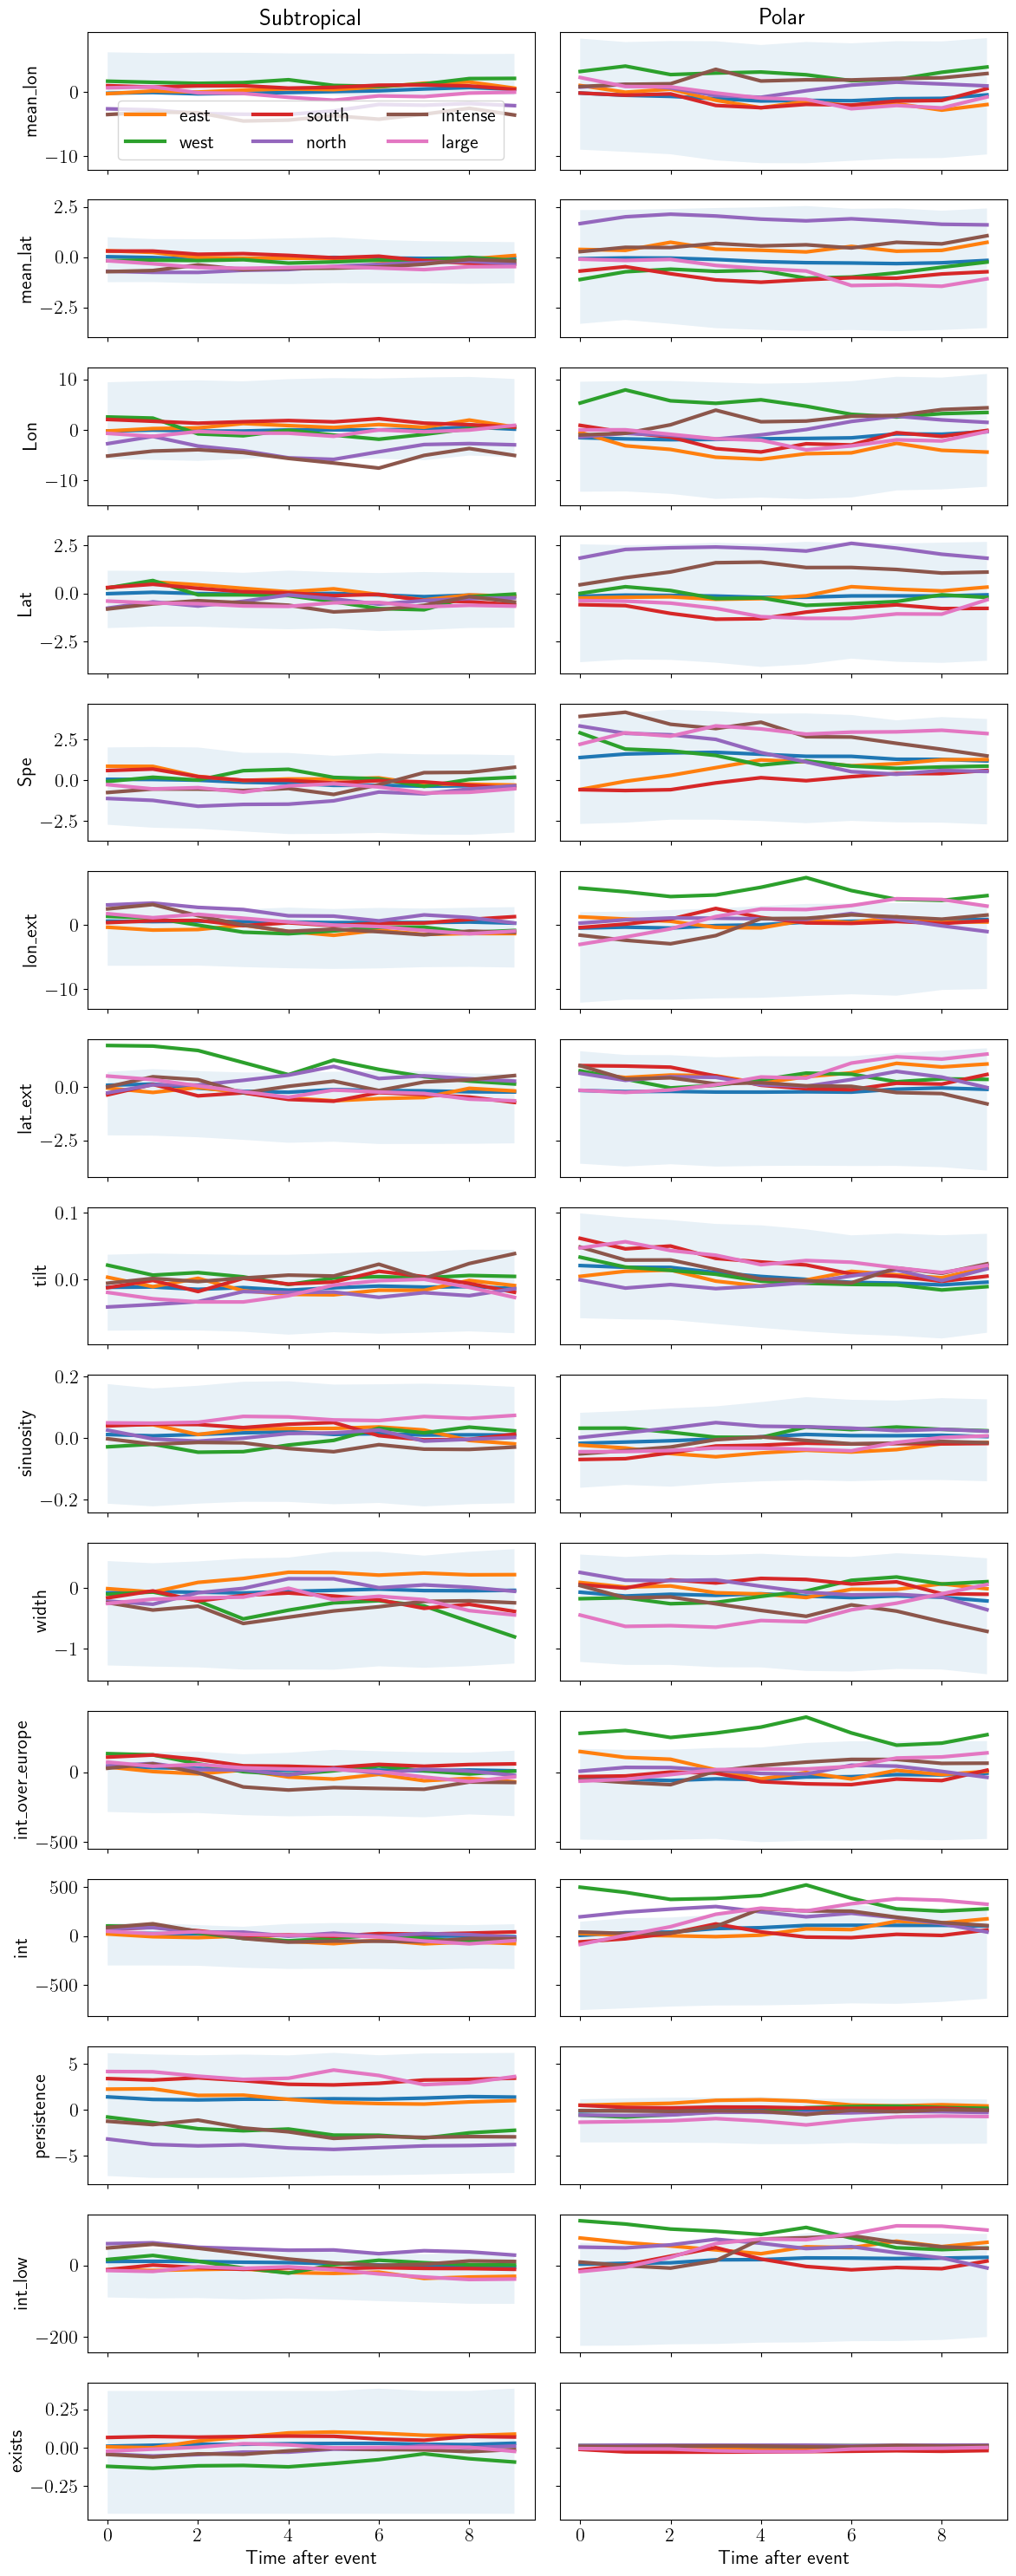

In [ ]:
fig, axes = plt.subplots(len(props_masked_pvs.data_vars), 2, figsize=(12, 30), sharex=True, sharey='row', tight_layout=True)
x = props_masked_pvs.time_around_event.values
q = 0.9
colors = ['blue', 'blue', 'green', 'green', 'red', 'purple']
linestyles = ['dashed', 'solid', 'dashed', 'solid', 'solid', 'solid']
for axs, varname in zip(axes, props_masked_pvs.data_vars):
    for ax, jet in zip(axs, props_masked_pvs.jet.values):
        da = props_masked_pvs[varname].sel(jet=jet)
        to_plot = da.mean(dim='event')
        ax.plot(x, to_plot.values, lw=3, color='black')
        q1, q2 = da.quantile([0.33, 0.66], dim='event').values
        ax.fill_between(np.arange(len(q1)), q1, q2, alpha=0.1, color='black')
        if jet == 'subtropical':
            ax.set_ylabel(varname)
        masks = {
            'east': da.com_x <= da.com_x.quantile(q=1 - q),
            'west': da.com_x >= da.com_x.quantile(q=q),
            'south': da.com_y <= da.com_y.quantile(q=1 - q),
            'north': da.com_y >= da.com_y.quantile(q=q),
            'intense': da.intensity >= da.intensity.quantile(q=q),
            'large': da.event_area >= da.event_area.quantile(q=q),
        }
        for (mask_name, mask), color, linestyle in zip(masks.items(), colors, linestyles):
            y = da.sel(event=mask).mean(dim='event').values
            ax.plot(x, y, label=mask_name, lw=3, color=color, linestyle=linestyle)
axes[0, 0].set_title('Subtropical')
axes[0, 1].set_title('Polar')
axes[-1, 0].set_xlabel('Time after event')
axes[-1, 1].set_xlabel('Time after event')
axes[0, 0].legend(ncol=3)

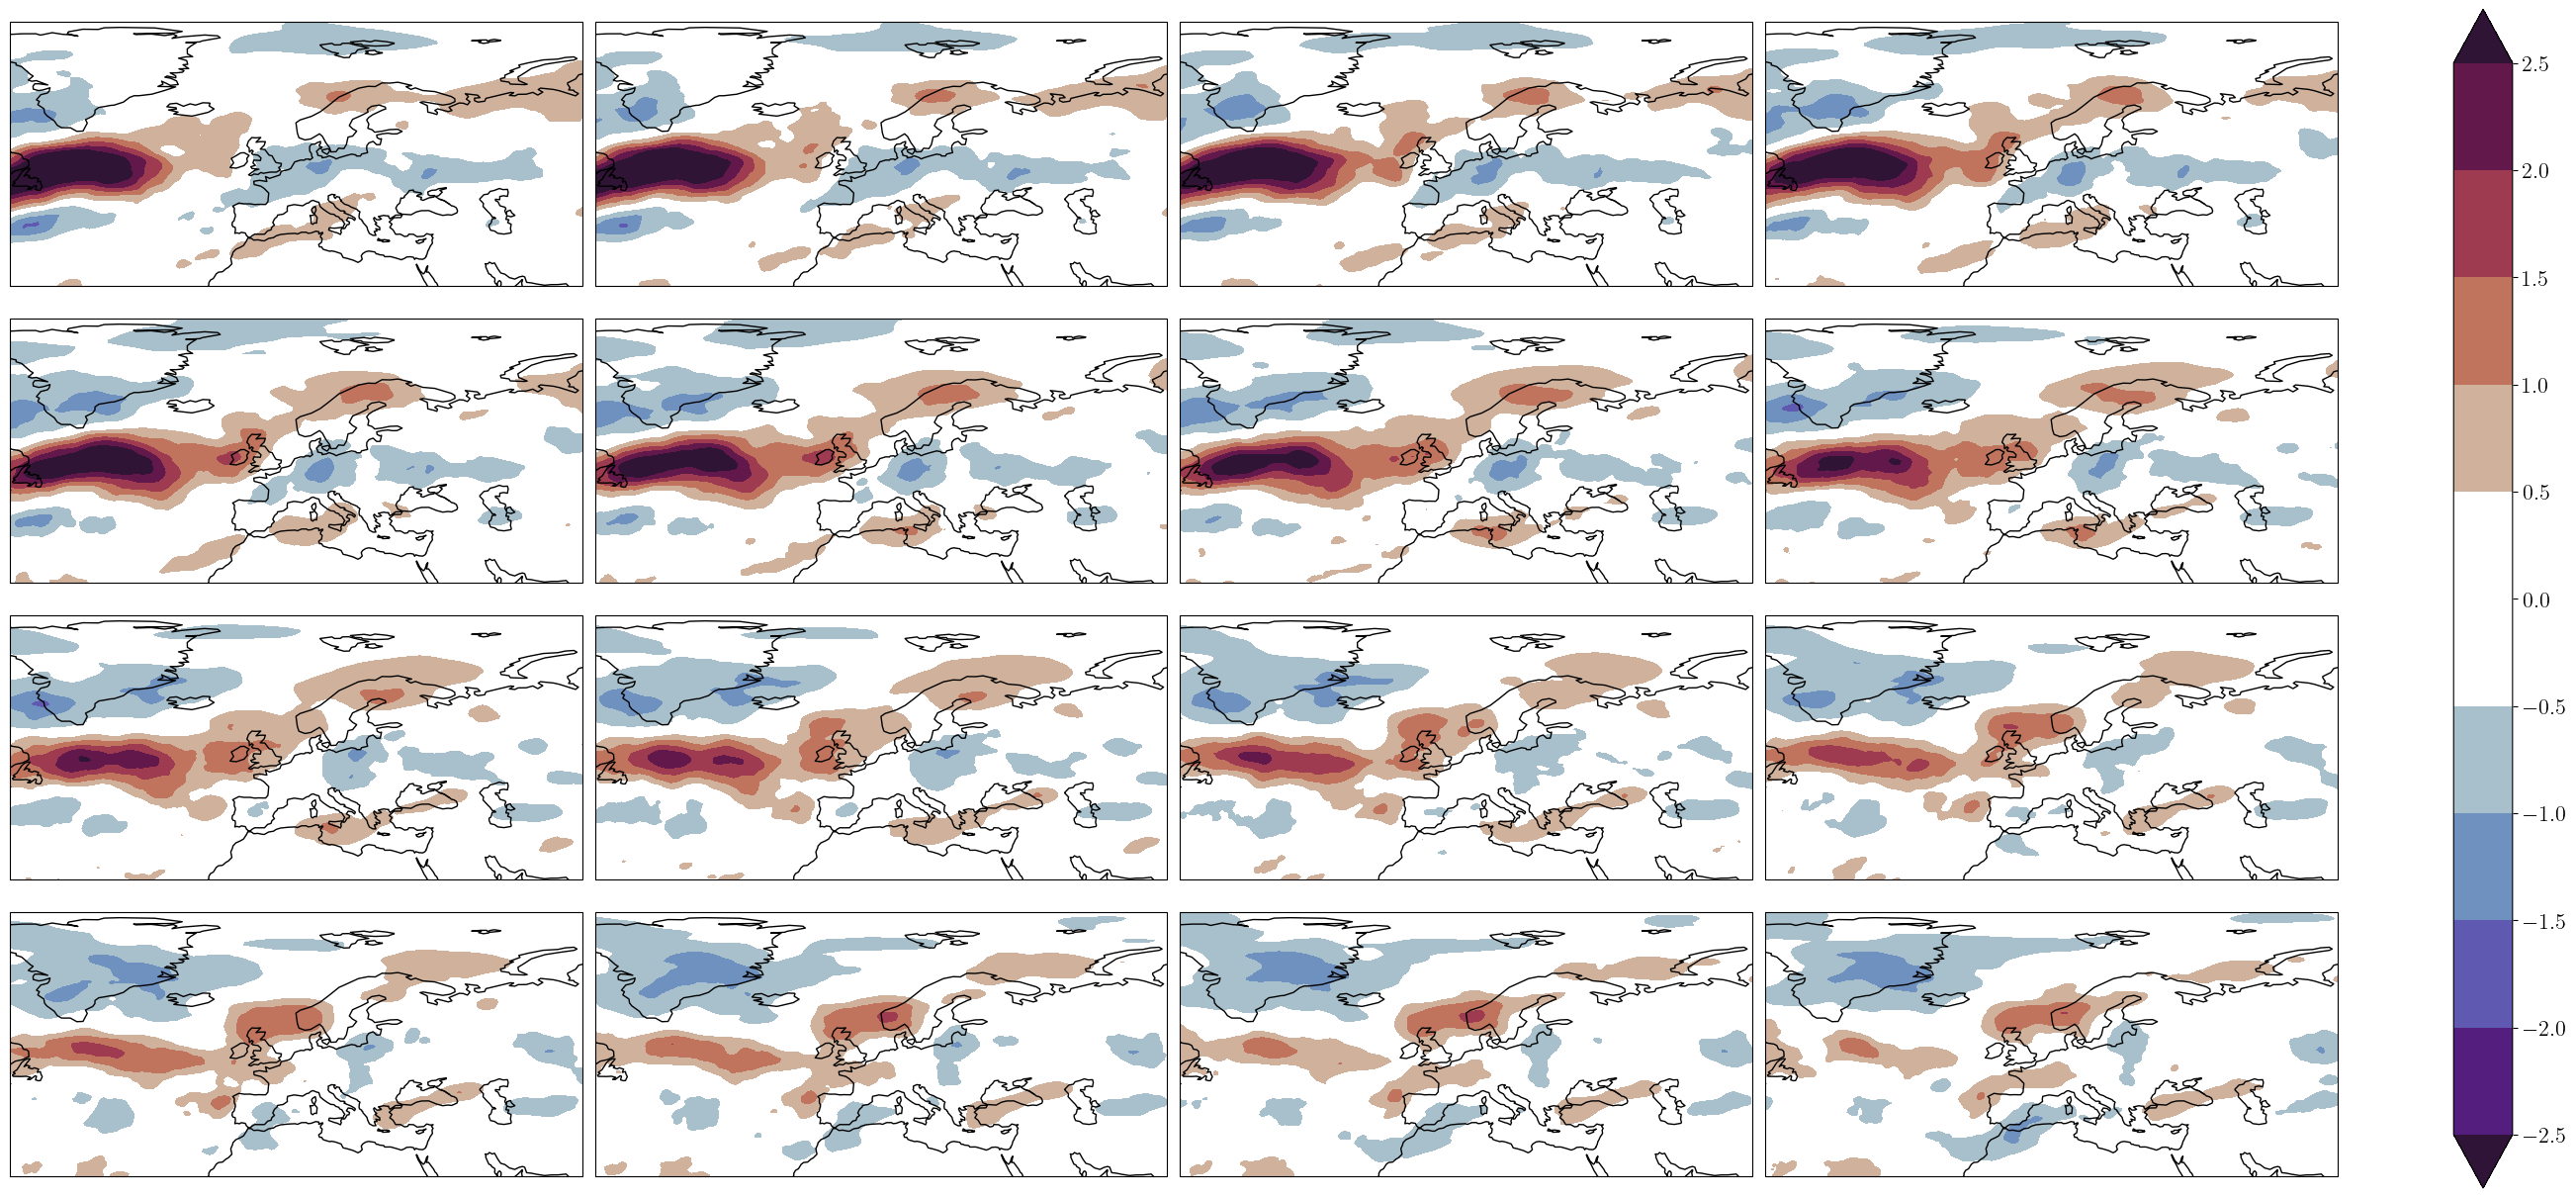

In [ ]:
clu = Clusterplot(4, 4, region=get_region(da))
_ = clu.add_contourf(da_masked_pvs[:16], transparify=True, q=0.99)